## PROTO V1.0
<div class='alert alert-success'>
Ce petit notebook permet d'évaluer Abstract Torch sur un petit réseau. 
Pour cela, on créé AbstractNN, un petit réseau composé de 3 couches de convolution suivies de ReLU, puis de deux couches FC suivies également de ReLU. 
Pour l'entrainement uniquement, un softmax est appliqué en sortie de réseau
</div>

Dans la classe AbstractNN, la méthode forward de nn.Linear est surchargée de façon standard.
C'est à dire que si l'on instancie model=AbstractNN(), model(x) applique forward à x comme dans n'importe quel réseau. 

AbstractNN possède une méthode abstract_forward() qui fait appelle à AbstractLinear et AbstractReLU. 
<div class='alert alert-info'>
Le lecteur avisé notera que 
    model(x)=nn.softmax(model.abstract_forward(x_abstract)[0])
</div>



In [7]:


%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn

from abstractModule import AbstractLinear as AL
from abstractModule import AbstractReLU as AR

from util.custom_train import CustomTrainer as T
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import random_split
from torch import optim
import os


device = torch.device('cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Ici on importe le dataset FashionMNIST normalisation et random split pour l'entrainement

In [8]:

path ='dataset'

os.makedirs(path, exist_ok=True)

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean =[0.5], std =[0.2]),
        #transforms.Resize((56,56))
    ])



dataset_train = datasets.FashionMNIST(root = path,transform = transform, download = True, train = True)
dataset_test =datasets.FashionMNIST( root =path,transform=transform ,download = True, train = False)
val =0.2
len_data_train = len(dataset_train)
train_size =int((1-val)*len_data_train)

val_size = int(val*len_data_train)

train_dataset, val_dataset = random_split(dataset_train, [train_size,val_size])


Ici on génère notre classe AbstractNN et sa fameuse méthode abstrac_forward


In [9]:


class AbstractNN(nn.Module):
    
    def __init__(self,num_depth=1,device=torch.device("cpu")):

        super(AbstractNN,self).__init__()
       
      
        self.num_depth = num_depth
        self.device = device
        self.conv1=nn.Conv2d(self.num_depth,16,3,device=self.device)
        self.conv2=nn.Conv2d(16,32,3,device=self.device)
  

       

        self.fc1=nn.Sequential(nn.Flatten(),nn.Linear(18432,64,device=self.device))
        self.fc2=nn.Sequential(nn.Flatten(),nn.Linear(64,10,device=self.device))
        self.softMax =nn.Softmax()
    def forward(self,x):
        x=self.conv1(x)
        x=torch.relu(x)
        x=self.conv2(x)
        x=torch.relu(x)
    
    
        x=self.fc1(x)
        x=torch.relu(x)
        x=self.fc2(x)
        x=torch.relu(x)
        x= self.softMax(x)
        return x
    
    def abstract_forward(self,x,add_symbol=False,device=torch.device("cpu")):
        self.device=device
        
        x_true = x
        x_true = x_true[0].unsqueeze(0)

        x,x_min,x_max,x_true = AL.abstract_conv2D(self.conv1,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
     
       
        x,x_min,x_max,x_true = AL.abstract_conv2D(self.conv2,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
       
        x,x_min,x_max,x_true = AL.abstract_linear(self.fc1,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
      
        x,x_min,x_max,x_true = AL.abstract_linear(self.fc2,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
       
        
        return x,x_min,x_max,x_true
        

Un petit script pour l'entrainement, disons 10 EPOCH

In [ ]:
model =AbstractNN(num_depth=1,device=torch.device('cpu'))

num_epochs =10
learning_rate=0.01
batch_size = 128

optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.99))
scheduler =  optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.98)
criterion = nn.CrossEntropyLoss()
TD= T(model=model,
            device=device
                            )
model = TD.train_model(train_dataset,val_dataset,
                        criterion=criterion,  
                        batch_size= batch_size,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        num_epochs=num_epochs,
                        learning_rate=learning_rate,
                        resname='SimpleCNN',verbose=False)

In [11]:
model=AbstractNN(num_depth=1,device=torch.device('cpu')    )
model.load_state_dict(torch.load('dataset/FMNIST.pth'))

<All keys matched successfully>

Label:9


torch.Size([1, 28, 28])

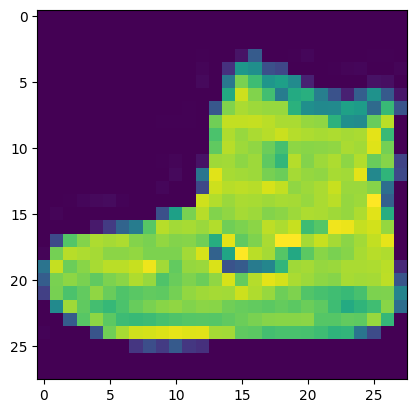

In [36]:
import matplotlib.pyplot as plt
import numpy as np

img, label = dataset_train[0]
plt.imshow(img[0])
print(f"Label:{label}")
img.shape

In [45]:
max= torch.max(img)
min = torch.min(img)
scale = max-min
print(scale)

from abstract import abstractTensor as AT

x=AT(img,alpha =0.01*scale*torch.ones(28*28))
x=x.abstract_tensor()
x.shape
x=x.to(device)
print(x.shape)


tensor(5.)
torch.Size([1, 28, 28])
torch.Size([786, 1, 28, 28])


In [42]:
with torch.no_grad():
   result_1= model(x[0].unsqueeze(0))  
 
   result,x_min,x_max,x_true=model.abstract_forward(x,add_symbol=False,device=torch.device('cpu'))

print(f"y_min       =  {x_min}")
print(f"y_max       =  {x_max}")
print(f"center Ztp  =  {result[0]}")
print(f"y_true      =  {x_true[:]}")
print(f"y_max-x_min =  {x_max-x_min}")
print(f"Trash symbol=  {result[-1]}")

/home/guillaume/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


x.shape=torch.Size([786, 1, 28, 28])
x.shape=torch.Size([786, 16, 26, 26])
y_min       =  tensor([ -7.0300, -15.9982, -10.3882,  -1.2775, -18.8381, -13.5925, -15.6110,
        -14.4627, -16.1567,  -3.8602])
y_max       =  tensor([10.1629, 22.5121, 14.2686,  1.3096, 35.4243, 19.8995, 28.0338, 30.4371,
        31.7835, 58.0758])
center Ztp  =  tensor([1.5665e+00, 3.2569e+00, 1.9402e+00, 1.6018e-02, 8.2931e+00, 3.1535e+00,
        6.2114e+00, 7.9872e+00, 7.8134e+00, 2.7108e+01])
y_true      =  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  2.2179,
          0.0000, 30.0349]])
y_max-x_min =  tensor([17.1929, 38.5103, 24.6568,  2.5871, 54.2624, 33.4920, 43.6448, 44.8997,
        47.9402, 61.9360])
Trash symbol=  tensor([ 8.1641, 18.1020, 11.5472,  1.2118, 24.1572, 15.5167, 19.6902, 20.4519,
        22.0462, 26.9331])


In [43]:
with torch.no_grad():
   result_1= model(x[0].unsqueeze(0))  
 
   result,x_min,x_max,x_true=model.abstract_forward(x,add_symbol=True,device=torch.device('cpu'))

print(f"y_min       =  {x_min}")
print(f"y_max       =  {x_max}")
print(f"center Ztp  =  {result[0]}")
print(f"y_true      =  {x_true[:]}")
print(f"y_max-x_min =  {x_max-x_min}")
print(f"Trash symbol=  {result[-1]}")


x.shape=torch.Size([786, 1, 28, 28])
x.shape=torch.Size([1937, 16, 26, 26])
y_min       =  tensor([ -0.4006,  -0.3760,  -0.3825,  -0.0000, -10.3307,  -2.3756,  -7.6219,
         -5.9288,  -7.4242,  13.0801])
y_max       =  tensor([ 0.4132,  0.3803,  0.3888,  0.0000, 18.4402,  2.6182, 12.5281, 13.5259,
        14.2173, 41.8671])
center Ztp  =  tensor([6.3187e-03, 2.1565e-03, 3.1072e-03, -0.0000e+00, 4.0548e+00, 1.2130e-01,
        2.4531e+00, 3.7985e+00, 3.3966e+00, 2.7474e+01])
y_true      =  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  2.2179,
          0.0000, 30.0349]])
y_max-x_min =  tensor([ 0.8138,  0.7563,  0.7713,  0.0000, 28.7708,  4.9939, 20.1499, 19.4547,
        21.6415, 28.7870])
Trash symbol=  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Voici le premier affichage de relevance calculé par AbstractTorch

tensor(9)
torch.Size([784])


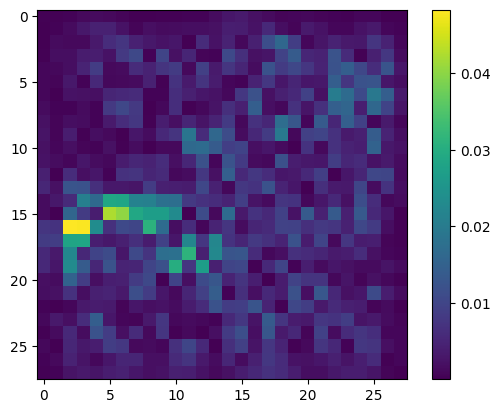

In [41]:
value=torch.argmax(result[0])
print(value)
concat= torch.abs(result[1:785,value])
print(concat.size())

concat = concat.reshape(28,28)
plt.imshow(torch.abs(concat.cpu()).numpy(), cmap='viridis')
plt.colorbar()

In [ ]:
print(result[3:5])

In [ ]:
conv= nn.Conv2d(1,16,3)
conv.weight.data=torch.abs(conv.weight.data)
conv.weight